# ECE 401 Lecture 7: Interpolation

This file is in the public domain.  You may freely re-use or re-distribute the whole or any part. 

## Outline of Today's lecture
* Decimation
* Upsampling 
* Piece-wise constant interpolation
* Piece-wise linear interpolation
* Piece-wise spline interpolation
* Sinc interpolation

# Preliminaries
First let's load some libraries, and some data.

Text(0.5, 1.0, 'Image of a cat with resolution (240, 424, 3)')

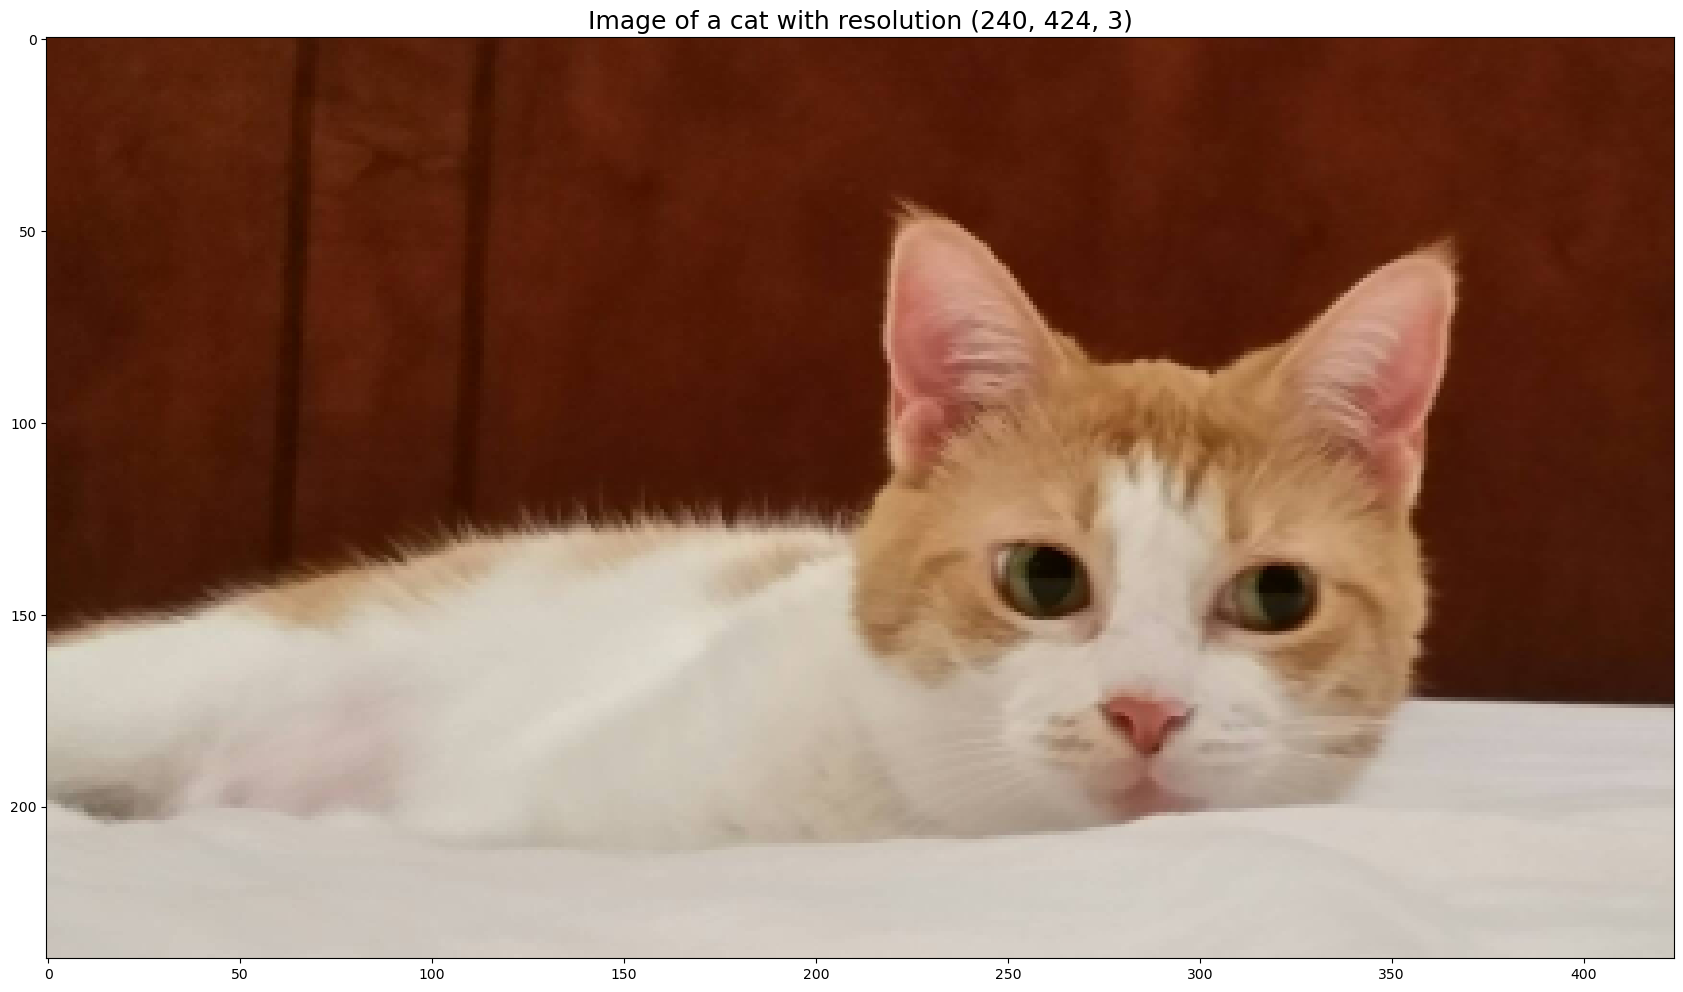

In [1]:
import imageio # for image i/o
import numpy as np  # general numeric operations and matrices
import io # for io.BytesIO, turns the data stream into a file-like object
import matplotlib.pyplot as plt # allows us to plot things
import urllib.request as request # downloads a file from the web
import math # for things like pi
%matplotlib inline
image_url = 'http://isle.illinois.edu/speech_web_lg/coursematerials/ece417/18fall/cat400.png'
cat400=imageio.v2.imread(io.BytesIO(request.urlopen(image_url).read())).astype(float)
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat400.astype('uint8'))
plt.title('Image of a cat with resolution {}'.format(cat400.shape),fontsize=18)


# Image as a signal

Notice that, in this case, the size of the image is $(240,480,3)$, meaning that it has 240 rows, 480 columns, and 3 colors.  `imageio` creates a numpy array indexed in that order (rows, columns, colors); other packages index in other orders, so you have to be careful each time you use a new package.  In any case, we can index this image as 

$$x[m,n,k]$$

where we'll use

* $m$ to index the row,
* $n$ to index the column,
* $k$ to index the color plane (red, green, or blue).

# Decimation

Decimation just means we remove $D-1$ out of every $D$ samples, thus
$$y[m,n,k]=x[mD,nD,k]$$



(60, 106, 3)


Text(0.5, 1.0, 'Cat Decimated to 60x106x3')

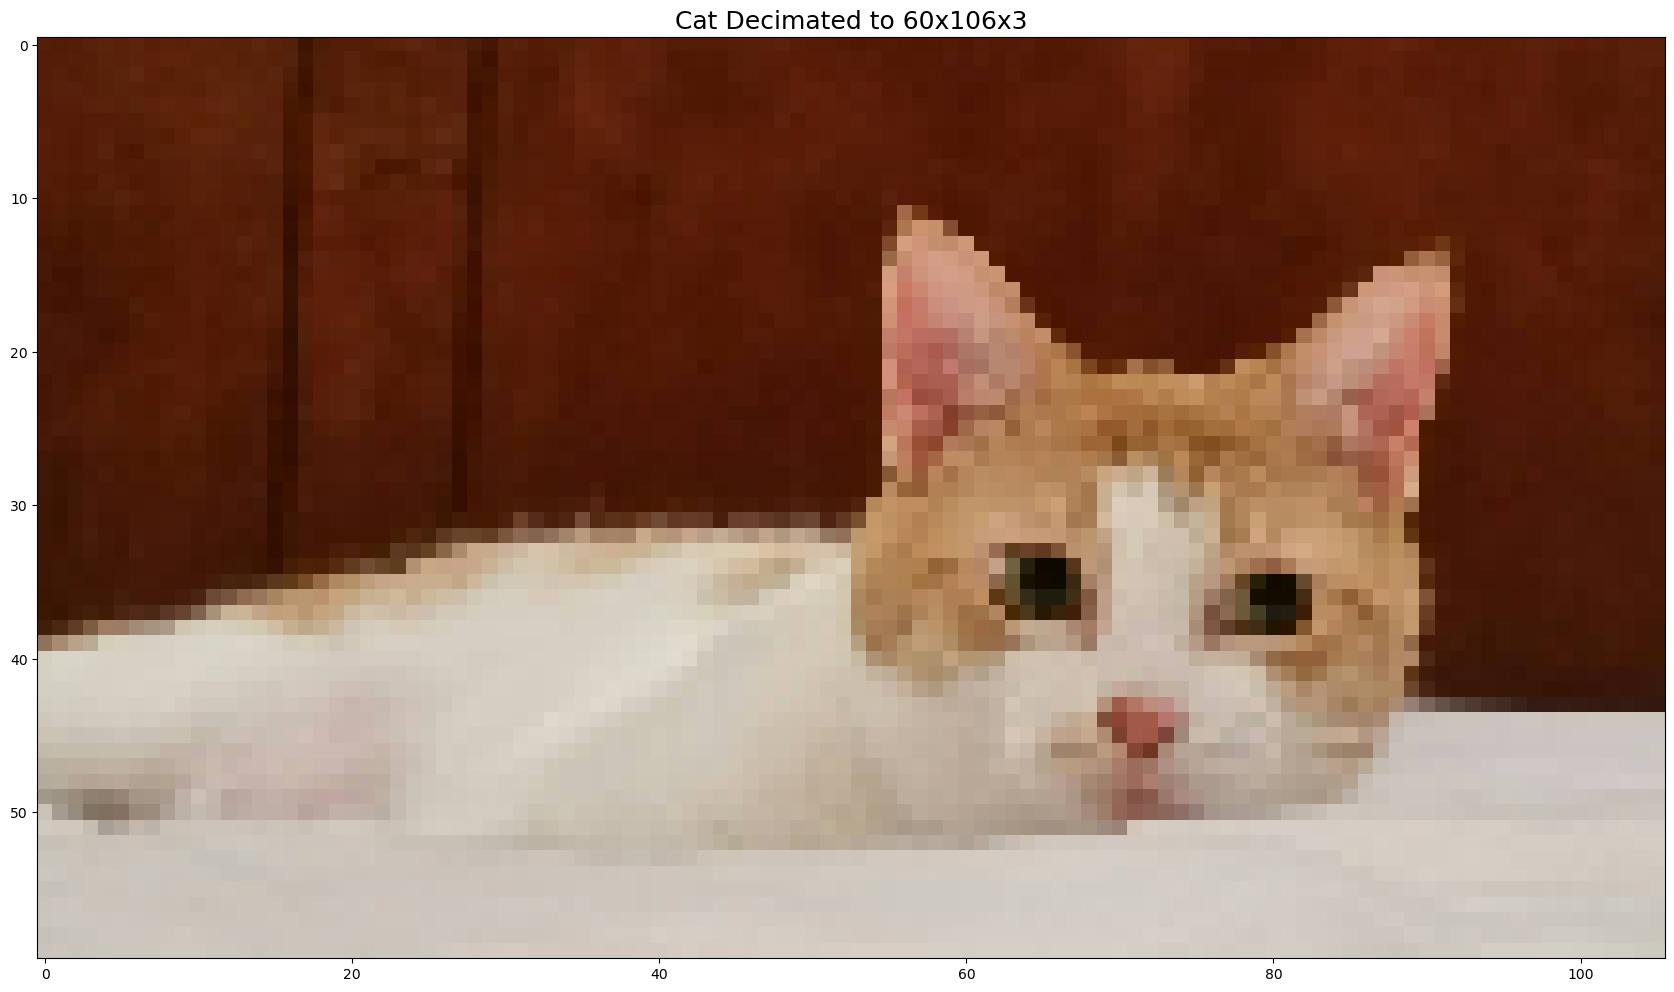

In [2]:
(M,N,K)=cat400.shape
cat100=cat400[::4,::4,:]
print(cat100.shape)
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat100.astype('uint8'))
plt.title('Cat Decimated to 60x106x3',fontsize=18)

Text(0.5, 1.0, 'Row 160 of fullsize image (blue), row 40 of decimated image (orange), color k=2')

<Figure size 640x480 with 0 Axes>

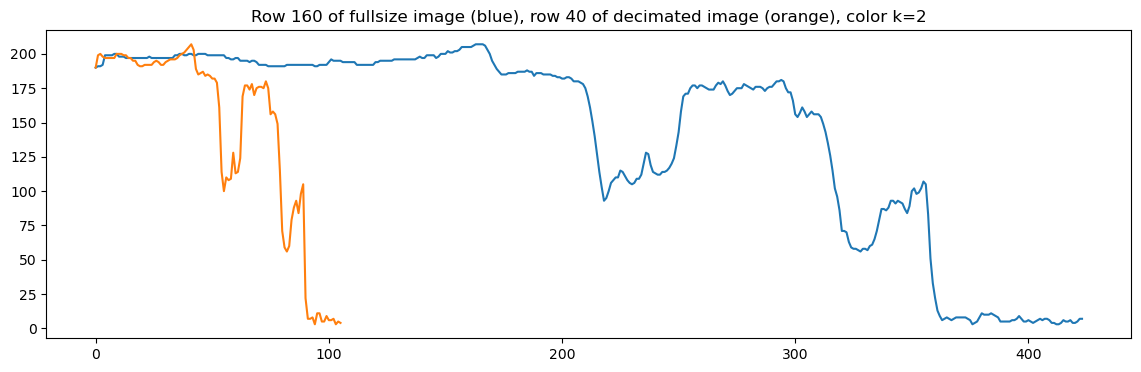

In [3]:
plt.figure()
t4=np.linspace(0,N-1,N,dtype='int16')
f1=plt.figure(figsize=(14,4))
plt.plot(t4,cat400[160,:,2],t4[:106],cat100[40,:,2])
plt.title('Row 160 of fullsize image (blue), row 40 of decimated image (orange), color k=2')



# Upsampling

Upsampling is the process of creating a larger image, from a smaller image, by just inserting zeros:
$$z[m,n,k] = \left\{\begin{array}{ll}
y[m/D,n/D,k] & m/D,~n/D~\mbox{are integers}\\
0 & \mbox{otherwise}
\end{array}\right.$$

Notice: $z[n]$ is exactly the same as the signal $v[n]$ that we saw before!! So it has aliasing.

Again, the problem is aliasing:
$$Z(\omega) = V(\omega) = Y(D\omega)$$

This time, though, the aliasing is much more visible in the image.  In fact, the image is mostly black dots, with a few spots of color (one per $D\times D$ square).


Text(0.5, 1.0, 'Cat that has been upsampled without interpolation')

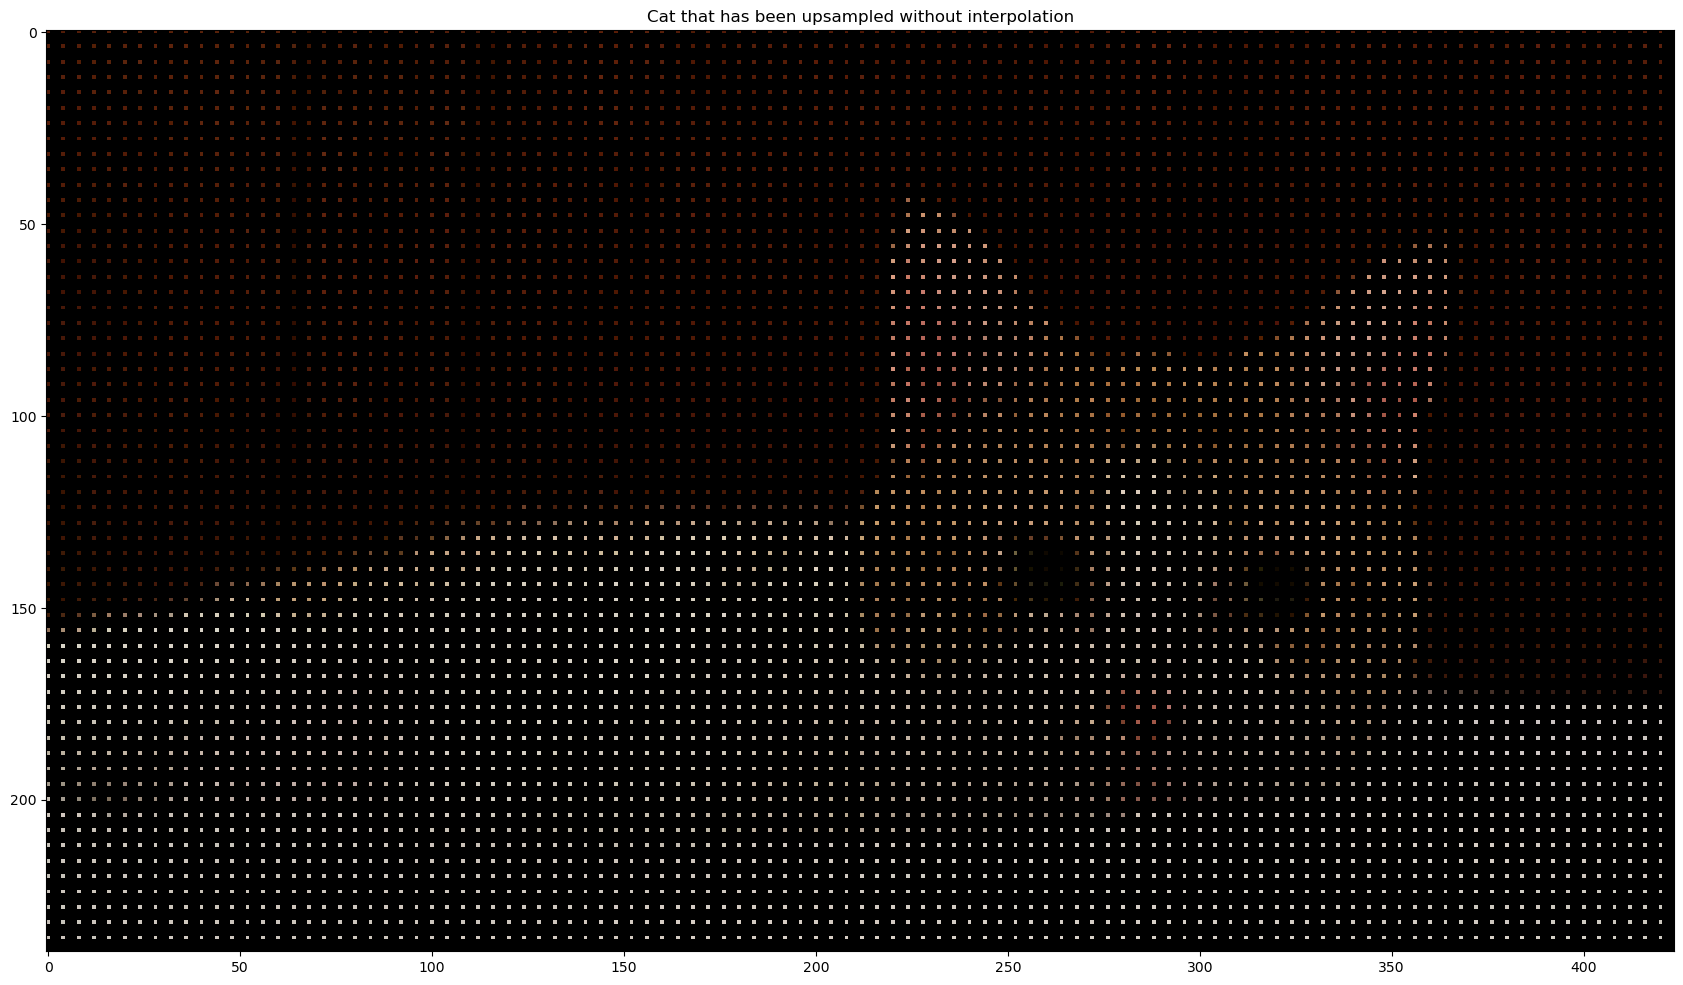

In [4]:
cat_upsampled = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,60):
    for n in range(0,106):
        for k in range(0,K):
            cat_upsampled[4*m,4*n,k]=cat100[m,n,k]
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_upsampled.astype('uint8'))
plt.title('Cat that has been upsampled without interpolation')

#  Piece-wise constant interpolation

The solution is obvious: rather than just filling zeros between the upsampled samples, we need to fill in some meaningful value.
The first solution to consider is piece-wise constant interpolation, sometimes called zero-order hold (ZOH).

$$z[m,n,k]=y[\mbox{int}(m/D),\mbox{int}(n/D),k]$$

This results in some aliasing, but not as bad as the upsampled cat.

Text(0.5, 1.0, 'Cat interpolated using PWC interpolation')

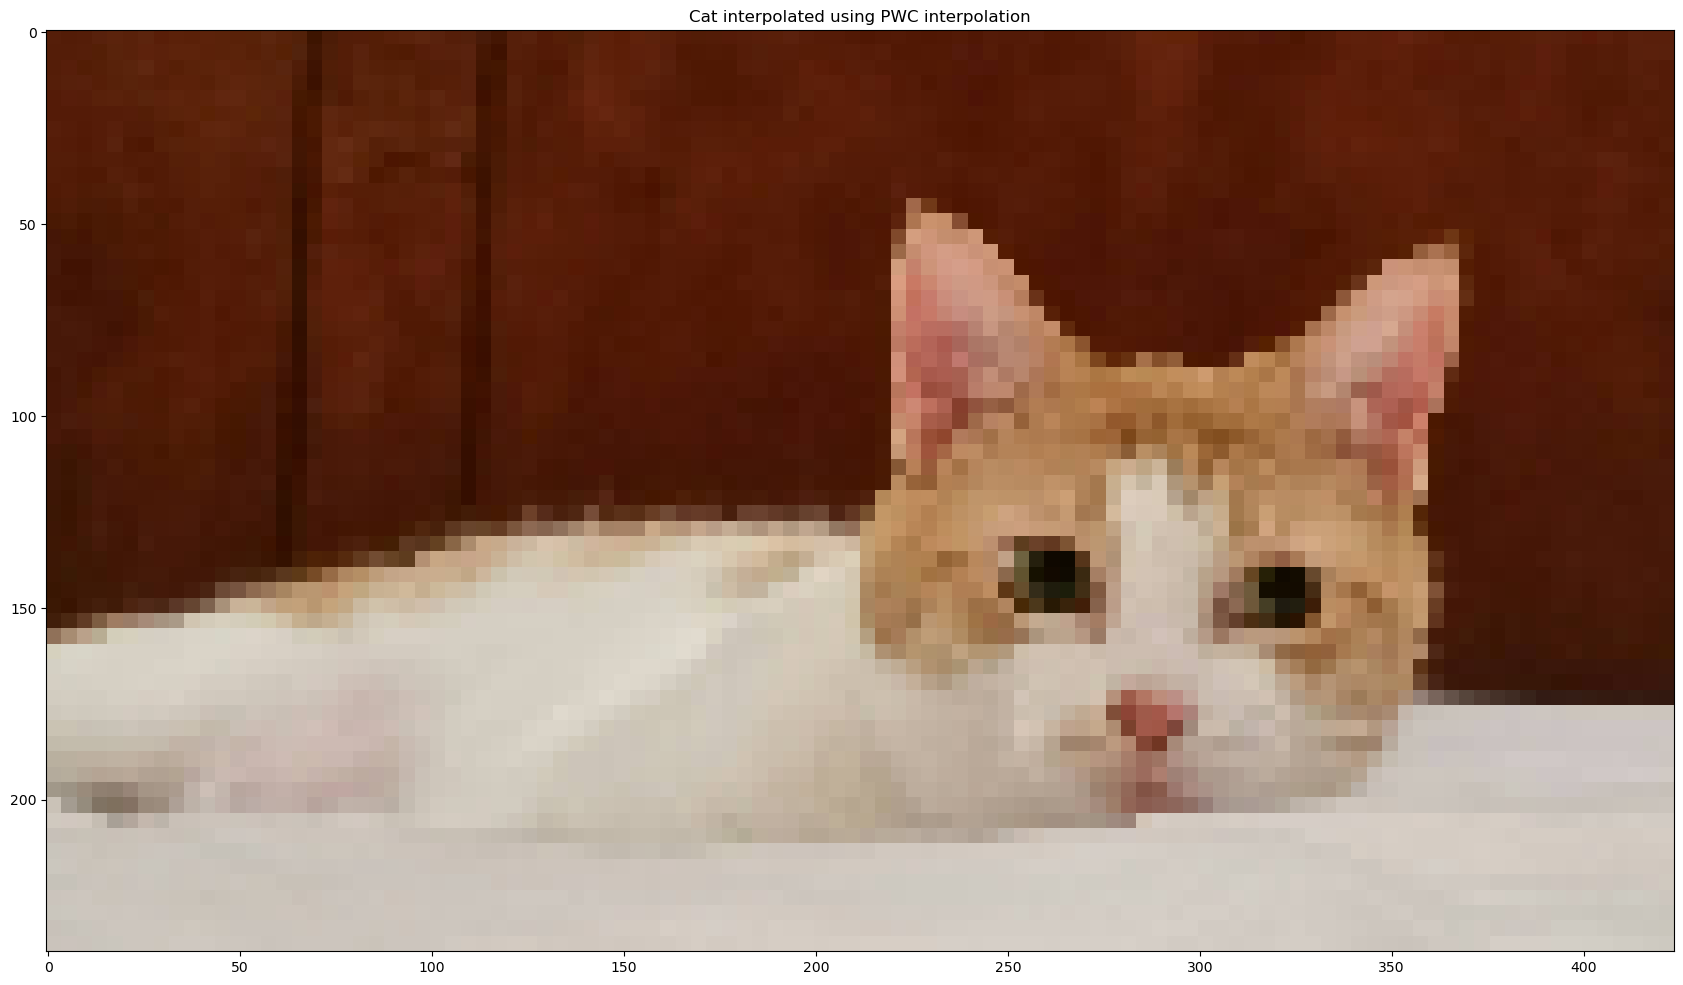

In [5]:
cat_pwc_double = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,240):
    for n in range(0,424):
        for k in range(0,K):
            cat_pwc_double[m,n,k]=cat100[int(m/4),int(n/4),k]
cat_pwc = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_pwc_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwc)
plt.title('Cat interpolated using PWC interpolation')

# Piece-wise linear (bilinear) interpolation

Piece-wise linear interpolation, in two dimensions at the same time, is called bilinear interpolation.

We can accomplish it by **literally** doing a piece-wise linear interpolation of the signal, as in the following code:

Text(0.5, 1.0, 'Cat upsampled using piece-wise linear interpolation')

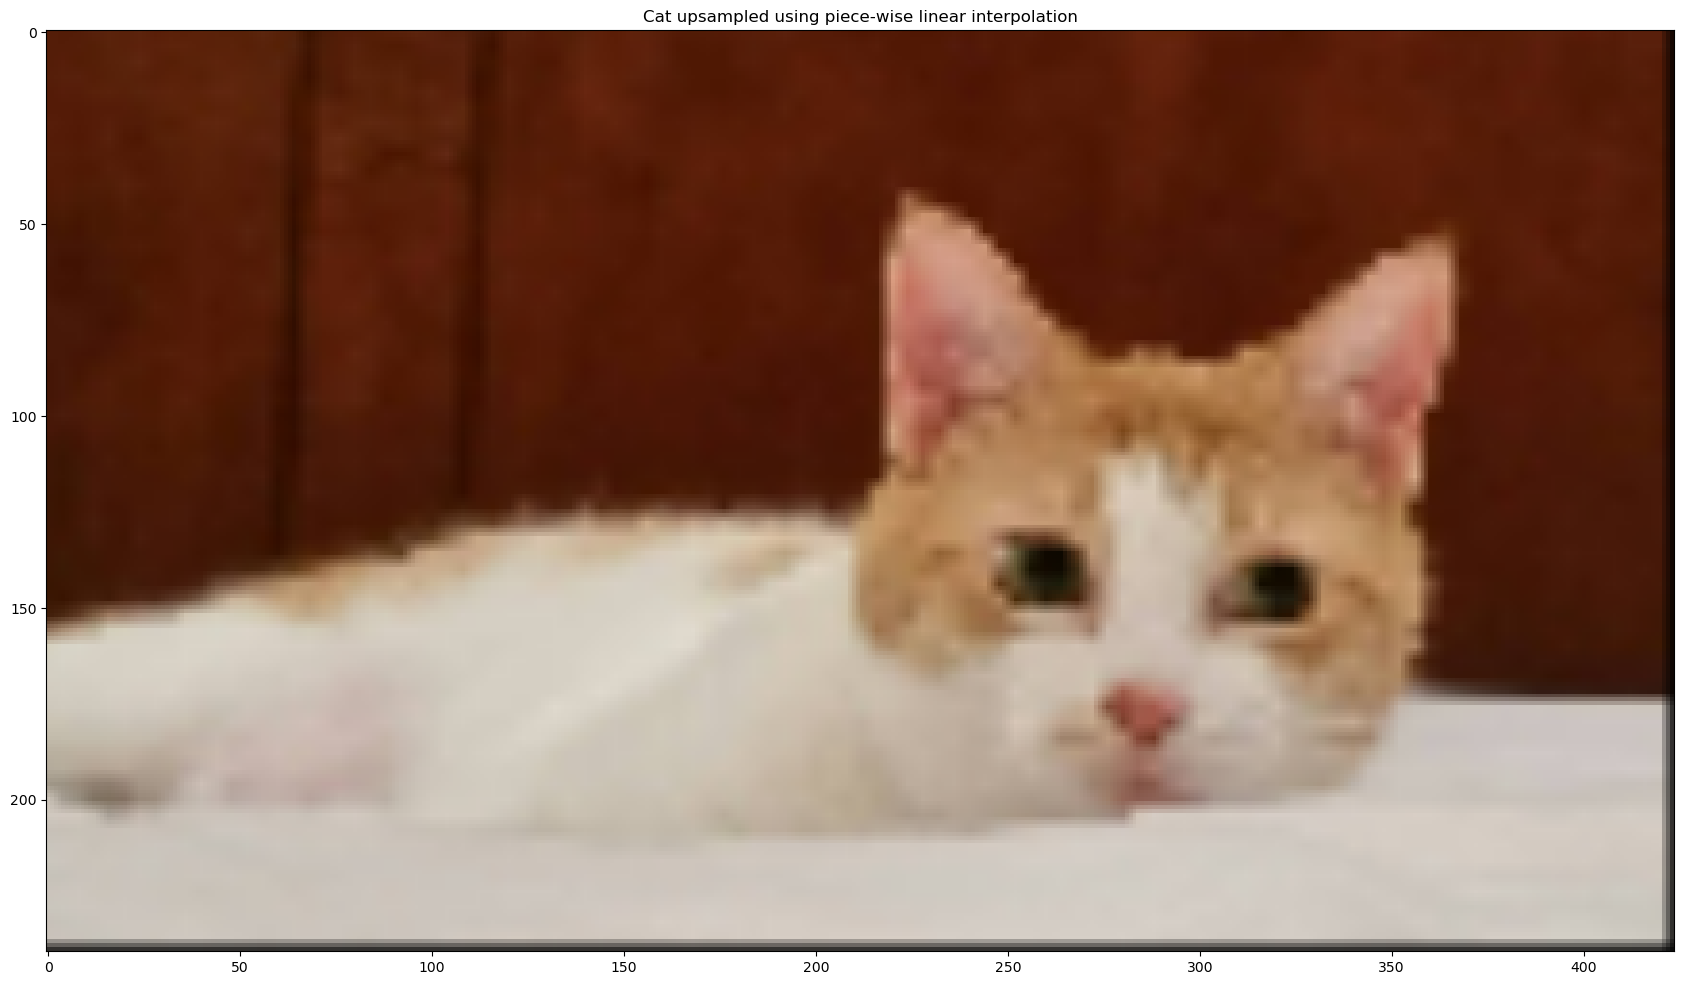

In [6]:
tmp = np.zeros((M,N,K))
cat_pwl = np.zeros((M,N,K))
for k in range(3):
    for m in range(M):
        for n in range(0,N,4):
            fp = [ cat_upsampled[m,n,k], cat_upsampled[m,min(N-1,n+4),k] ]
            tmp[m,n:n+4,k]=np.interp([0,1,2,3],[0,4], fp)
    for n in range(N):
        for m in range(0,M,4):
            fp = [ tmp[m,n,k], tmp[min(M-1,m+4),n,k] ]
            cat_pwl[m:m+4,n,k] = np.interp([0,1,2,3],[0,4], fp)

plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwl.astype('uint8'))
plt.title('Cat upsampled using piece-wise linear interpolation')

Notice that piece-wise-linear interpolation is just like upsampling the cat, and then convolving with the piece-wise linear interpolation filter:

$$h_{PWL}[n] = \left\{\begin{array}{ll}
\frac{D-|n|}{D} & -D\le n\le D\\
0 & \mbox{otherwise}\end{array}\right.
$$

Similarly, piece-wise constant interpolation is just like upsampling the cat, and then convolving with the piece-wise constant interpolation filter:

$$h_{PWC}[n] = \left\{\begin{array}{ll} 1 & 0\le n<D\\
0 & \mbox{otherwise}\end{array}\right.$$

Text(0.5, 1.0, 'PWL Interpolation is like convolving with the PWL interpolator')

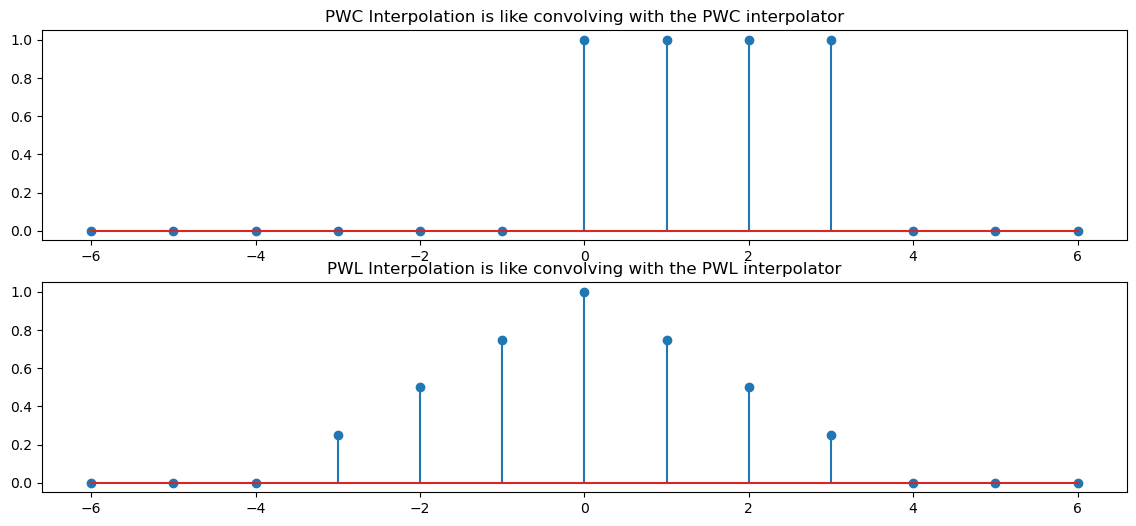

In [7]:
zero_sample = 6
n_axis = np.linspace(-zero_sample,zero_sample, 2*zero_sample+1, dtype='int16')
h_pwc = np.zeros(13)
h_pwl = np.zeros(13)
for n in range(0,4):
    h_pwc[zero_sample+n]=1
    h_pwl[zero_sample+n]=0.25*(4-n)
    h_pwl[zero_sample-n]=0.25*(4-n)
plt.figure(1,figsize=(14,6))
plt.subplot(211)
plt.stem(n_axis,h_pwc)
plt.title('PWC Interpolation is like convolving with the PWC interpolator')
plt.subplot(212)
plt.stem(n_axis,h_pwl)
plt.title('PWL Interpolation is like convolving with the PWL interpolator')

Just to prove it, let's recompute the bilinear-interpolated cat using the triangle filter above, and show that it's the same image.

Text(0.5, 1.0, 'Cat upsampled using a triangle interpolation kernel')

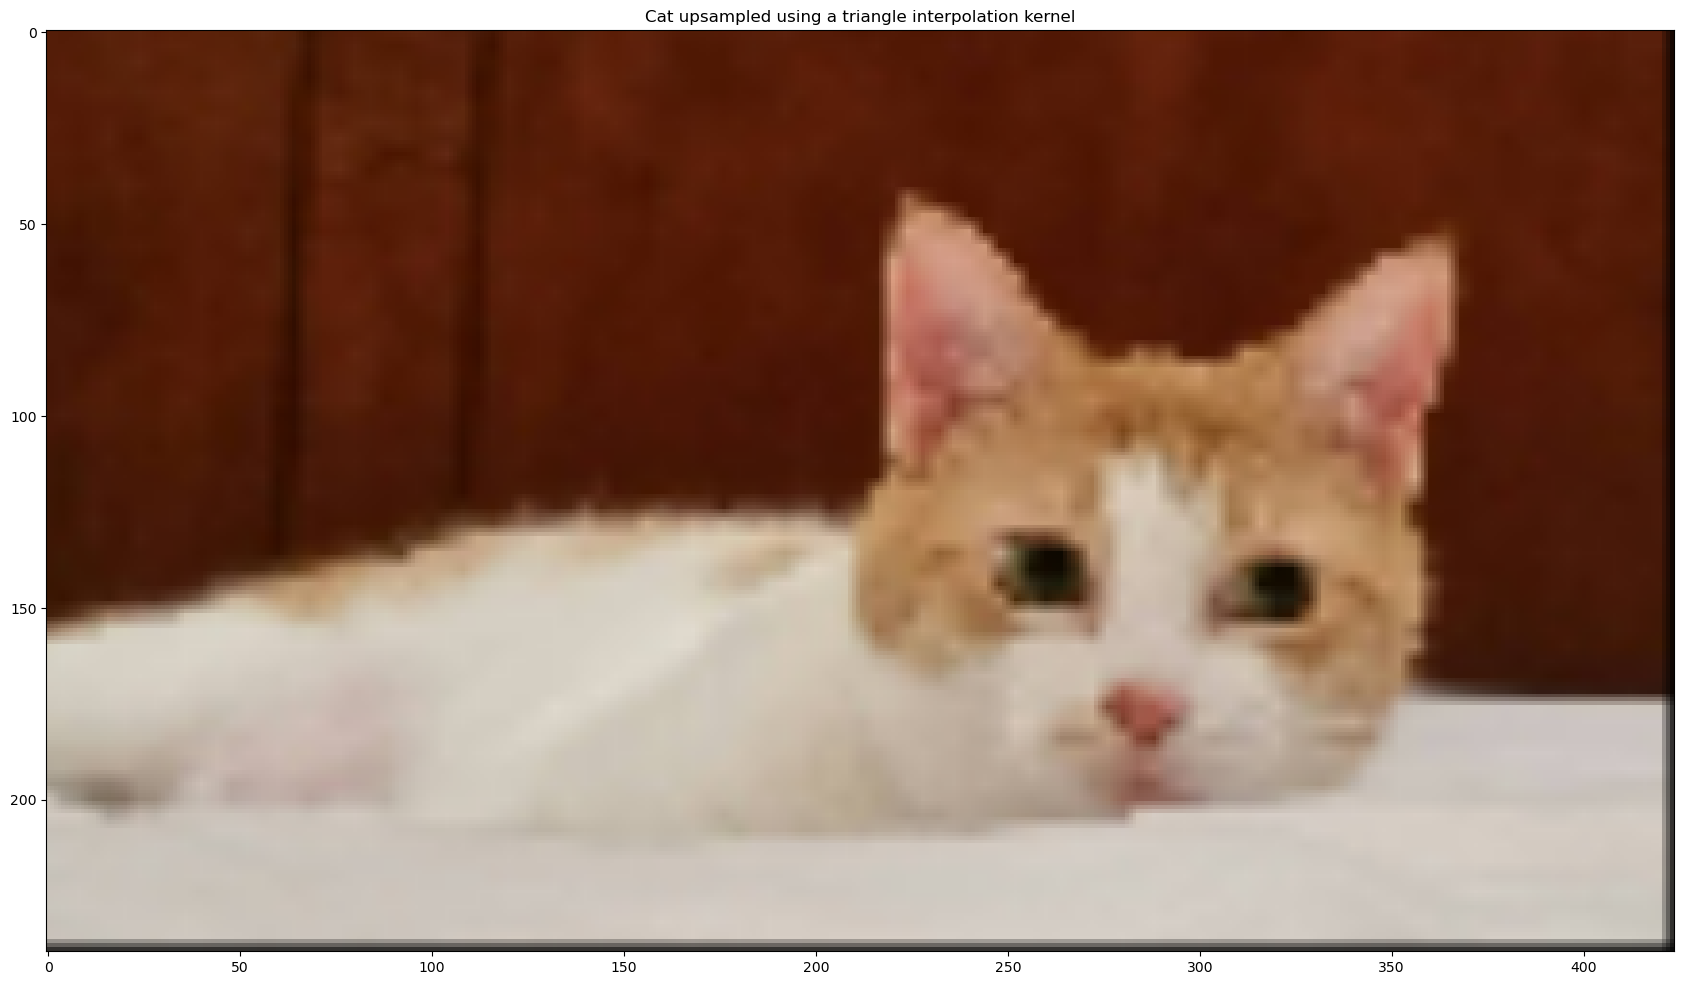

In [8]:
tmp = np.zeros((M,N,K))
cat_triangle = np.zeros((M,N,K))
for k in range(3):
    for m in range(M):
        tmp[m,:,k] = np.convolve(cat_upsampled[m,:,k],h_pwl,mode='same')
    for n in range(N):
        cat_triangle[:,n,k] = np.convolve(tmp[:,n,k], h_pwl, mode='same')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_triangle.astype('uint8'))
plt.title('Cat upsampled using a triangle interpolation kernel')

# Sinc Interpolation

PWC interpolation suffers from obvious blocky artifacts.  PWL interpolation smooths away most of those, but not all.
We can get rid of all of them, and get the lowpass-filtered cat back again exactly, by filtering the upsampled cat
using an ideal sinc function.

$$z[n]=D^2  h_{LPF}[n]\ast y[n]$$

Multiplying by a factor of $D^2$ is necessary because we're trying to construct $D^2$ output samples from every one input sample. 

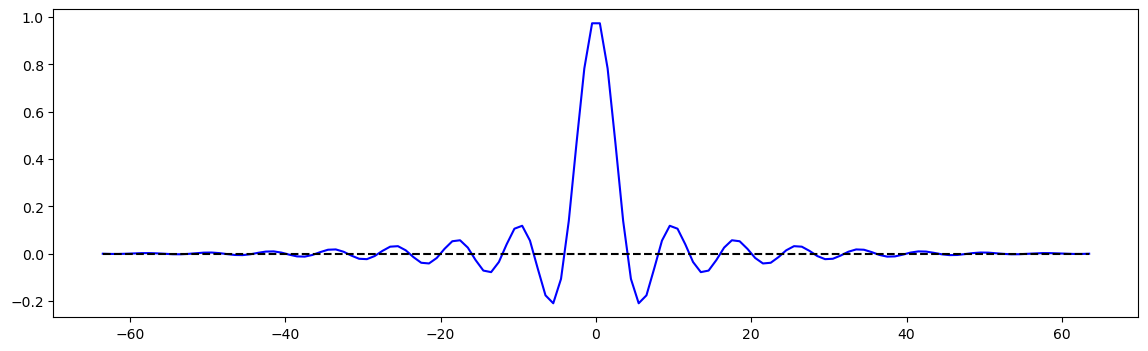

In [9]:
n = np.arange(-63.5,64.5)
lpf = np.hamming(128) * np.sinc(n/4)
fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot(n,lpf, 'b-', n, np.zeros(n.shape), 'k--')

Text(0.5, 1.0, 'Cat upsampled using sinc interpolation')

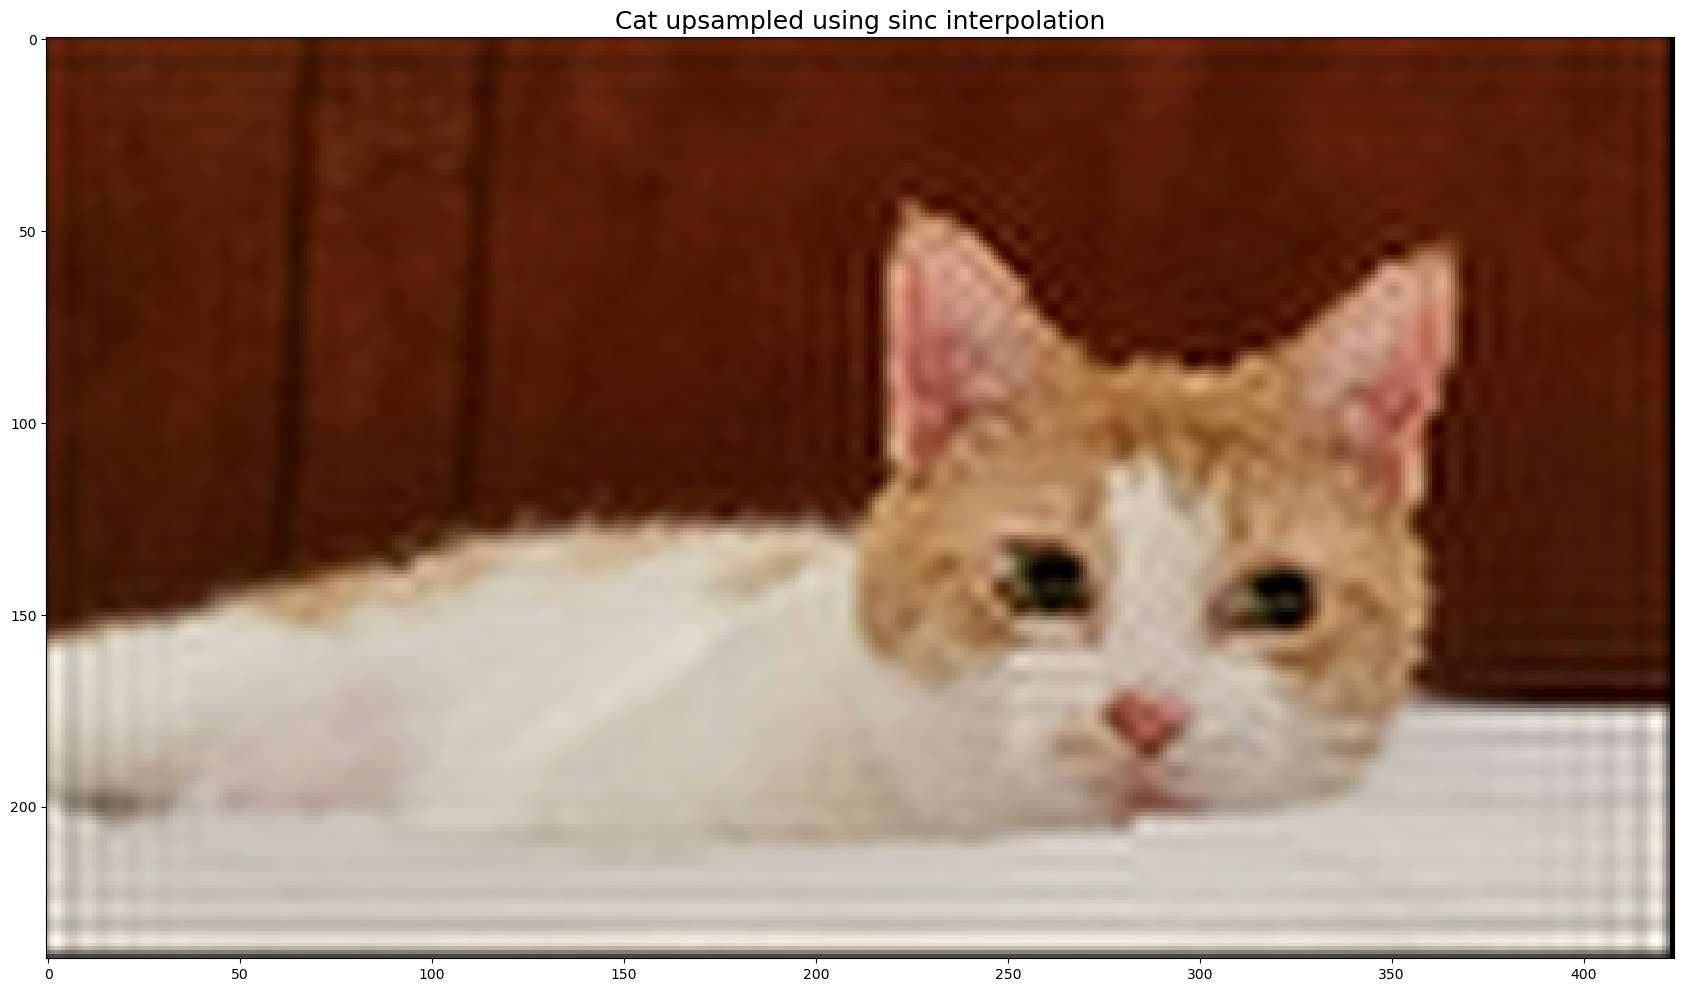

In [10]:

cat_si=np.zeros((240,424,3),dtype='double')
tmp=np.zeros((240,424,3),dtype='double')
for k in range(0,K):
    for m in range(0,M):
        tmp[m,:,k]=np.convolve(cat_upsampled[m,:,k],lpf,mode='same')
    for n in range(0,423):
        cat_si[:,n,k]=np.convolve(tmp[:,n,k],lpf,mode='same')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(np.minimum(255,np.maximum(0,cat_si)).astype('uint8'))
plt.title('Cat upsampled using sinc interpolation',fontsize=18)

# Summary of Visible Artifacts
* PWC: blocky artifacts
* PWL (Bilinear): some blocky artifacts because it interpolates within blocks, but the artifacts are a lot less than PWC interpolation.  Often, this is the best option.
* Sinc: ringing artifacts, that occur at sharp boundaries between two colors, and at the edge of the image, depending on how you handle edges.


